In [8]:
import numpy as np #numpy gives us better array management

import matplotlib  #ploting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#PSF convolution
from scipy.signal import fftconvolve

#Used to resize Kernels
from skimage.transform import downscale_local_mean, resize
#from skimage import transform as tf #To manipulate images

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm.notebook import trange

In [112]:
from photutils.aperture import CircularAperture,aperture_photometry
from photutils.centroids import centroid_com

In [242]:
class ModelPars:
    """Default Model Parameters
    """

    nplanetmax=9 #code is hardwired to have upto 9 transiting planets.
    #default parameters -- these will cause the program to end quickly
    tstart=0.0 #start time (days)
    tend=1.0 #end time (days)
    iframe=2 #number of frames used to generate exposure time (needed for pointing jitter)
    exptime=1 #exposure time (s)
    deadtime=0.0 #dead time (s)
    modelfile='null' #stellar spectrum file name
    nmodeltype=2 #stellar spectrum type. 1=BT-Settl, 2=Atlas-9+NL limbdarkening
    rvstar=0.0 #radial velocity of star (km/s)
    vsini=0.0 #projected rotation of star (km/s)
    pmodelfile=[None]*nplanetmax #file with Rp/Rs values
    pmodeltype=[None]*nplanetmax #Type of planet file
    emisfile=[None]*nplanetmax #file with emission spectrum
    ttvfile=[None]*nplanetmax #file with O-C measurements
    #nplanet is tracked by pmodelfile.
    nplanet=0 #number of planets -- default is no planets - you will get staronly sim.
    sol=np.zeros(nplanetmax*8+1)
    sol[0]=1.0 #mean stellar density [g/cc]
    xout=256  #x-axis
    xpad=10    #padding to deal with convolution fall-off
    ypad=10    #padding to deal with convolution fall-off
    yout=256   #y-axis
    noversample=2 #oversampling
    gain=1.6 # electronic gain [e-/adu]
    saturation=65536.0 #saturation
    jitter_dis=1.0 #pointing jitter in dispersion axis [pixels, rms]
    jitter_spa=1.0 #pointing jitter in spatial axis [pixels, rms]
    readnoise=8.0 #readnoise electrons
    gain=6.1 #e-/ADU

def addflux2pix(px,py,pixels,fmod):
    """Usage: pixels=addflux2pix(px,py,pixels,fmod)

    Drizel Flux onto Pixels using a square PSF of pixel size unity
    px,py are the pixel position (integers)
    fmod is the flux calculated for (px,py) pixel
        and it has the same length as px and py
    pixels is the image.
    """

    xmax = pixels.shape[0] #Size of pixel array
    ymax = pixels.shape[1]

    pxmh = px-0.5 #location of reference corner of PSF square
    pymh = py-0.5

    dx = np.floor(px+0.5)-pxmh
    dy = np.floor(py+0.5)-pymh

    # Supposing right-left as x axis and up-down as y axis:
    # Lower left pixel
    npx = int(pxmh) #Numpy arrays start at zero
    npy = int(pymh)

    #print('n',npx,npy)
    
    #if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
    #    pixels[npx,npy]=pixels[npx,npy]+fmod
    
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*dx*dy

    #Same operations are done for the 3 pixels other neighbouring pixels

    # Lower right pixel
    npx = int(pxmh)+1 #Numpy arrays start at zero
    npy = int(pymh)
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*(1.0-dx)*dy

    # Upper left pixel
    npx = int(pxmh) #Numpy arrays start at zero
    npy = int(pymh)+1
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*dx*(1.0-dy)

    # Upper right pixel
    npx = int(pxmh)+1 #Numpy arrays start at zero
    npy = int(pymh)+1
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*(1.0-dx)*(1.0-dy)
    
    return pixels;

def gauss2d(x,y,sig):
    g=1/(2*np.pi*sig*sig) * np.exp(-(x*x+y*y)/(2*sig*sig))
    return g

def gen_unconv_image(pars,starmodel_flux,xcoo,ycoo):

    xpad=pars.xpad*pars.noversample
    ypad=pars.ypad*pars.noversample
    #array to hold synthetic image
    xmax=pars.xout*pars.noversample+xpad*2
    ymax=pars.yout*pars.noversample+ypad*2

    pixels=np.zeros((xmax,ymax))
    
    i=xcoo*pars.noversample
    j=ycoo*pars.noversample
    
    pixels=addflux2pix(i,j,pixels,starmodel_flux)
    
    return pixels

In [322]:
def readkernels(psf_dir,psf_names):
    """Reads in PSFs from Matlab file and resamples to match pixel grid of simulation.
    
    Usage: psf=readkernels(psf_dir,psf_names)
    
        Inputs:
            psf_dir - location of PSFs
            psf_names - names of the PSF files to read in.  Order should match 'psf_wv' array
          
        Outputs:
            psf - array of PSFs.
    """
    
    detector_pixscale=18 #detector pixel size (microns)  ***This should be a model parameter***
    
    psf=[]
    for name in psf_names:
        mat_dict=loadmat(psf_dir+psf_names[0]) #read in PSF from Matlab file
        
        psf_native=mat_dict['psf']
        dx_scale=mat_dict['dx'] #scale in micron/pixel of the PSF
        x_scale=int(psf_native.shape[0]*dx_scale/detector_pixscale*pars.noversample) #This gives the PSF size in pixels 
        y_scale=int(psf_native.shape[1]*dx_scale/detector_pixscale*pars.noversample) #This gives the PSF size in pixels 
        
        #We now resize the PSF from psf.shape to x_scale,yscale
        psf_resize=resize(psf_native,(x_scale,y_scale))
        psf.append(psf_resize)
        
        #plt.imshow(psf_resize,norm=LogNorm())
        #plt.show()
        
    return psf

In [324]:
#Used to read in Kernels
from scipy.io import loadmat

In [328]:
workdir='/data/rowe/pandora/'
psf_dir=workdir+'Kernels/'
psf_wv=[1.4]
#psf_names=['Pandora_nir_20210602.mat']
psf_names=['Pandora_nir_20210602_trefoil.mat']

psf=readkernels(psf_dir,psf_names)
psf[0]=psf[0]/np.sum(psf[0])

In [329]:
psf[0].shape

(261, 261)

In [330]:
pars=ModelPars
starmodel_flux=2**14


psf_sigma=1.1 #starting value of PSF width
nexp=100 #number of exposures
siggrow=0.0 #how much to grow the PSF (pixels)
signorm=0.25 #how much variation to add to PSF width
nstack=30

dsig=[]
pscat=[]

#for signorm in np.linspace(0.1,1.0,10):
    
phot_array=[]
phot_err_array=[]
time=[]
t=0

npsf=len(psf)
for i in range(npsf):
    #We now resize the PSF from psf.shape to x_scale,yscale
    x_scale=psf[i].shape[0]*pars.noversample
    y_scale=psf[i].shape[1]*pars.noversample
    psf[i]=resize(psf[i],(x_scale,y_scale))

for iexp in trange(nexp):

    pixels_final=np.zeros((pars.xout,pars.yout))
    for istack in range(nstack):

        #psf=[]
        #psf.append(np.zeros((64,64))) #Kernel size for convolution
        #
        #imid=psf[0].shape[0]/2
        #jmid=psf[0].shape[1]/2
        #sig=psf_sigma+iexp/nexp*siggrow+signorm*np.random.rand()
        #
        #for i in range(psf[0].shape[0]):
        #    x=i-imid 
        #    for j in range(psf[0].shape[1]):
        #        y=j-jmid
        #        psf[0][i,j]=gauss2d(x,y,sig)
        #
        #npsf=len(psf)
        #for i in range(npsf):
        #    #We now resize the PSF from psf.shape to x_scale,yscale
        #    x_scale=psf[i].shape[0]*pars.noversample
        #    y_scale=psf[i].shape[1]*pars.noversample
        #    psf[i]=resize(psf[i],(x_scale,y_scale))

        for icount in range(pars.iframe):

            #adding pointing jitter
            xjit=np.random.normal()*pars.jitter_dis
            yjit=np.random.normal()*pars.jitter_spa
            xcoo=pars.xout/2+xjit+xpad/2
            ycoo=pars.yout/2+yjit+ypad/2

            if icount==0:
                pixels=gen_unconv_image(pars,starmodel_flux,xcoo,ycoo)
            else:
                pixels1=gen_unconv_image(pars,starmodel_flux,xcoo,ycoo)
                pixels+=pixels1
        pixels=pixels/pars.iframe

        #Create Convolved Image
        pixels_conv=fftconvolve(pixels, psf[0], mode='same')

        #remove padding
        pshape=pixels_conv.shape
        xpad=pars.xpad*pars.noversample
        ypad=pars.ypad*pars.noversample
        pixels_conv_ras=pixels_conv[ypad:pshape[0]-ypad,xpad:pshape[1]-xpad]
        #print(np.sum(pixels_conv_tf_ras))

        #Scale to native resolution (remove oversampling.)
        pixels_conv_ras_nav=downscale_local_mean(pixels_conv_ras,(pars.noversample,pars.noversample))

        #add Noise.
        #Shot-noise
        pixels_conv_ras_nav_noise=pixels_conv_ras_nav+np.sqrt(np.abs(pixels_conv_ras_nav))*\
                                                      np.random.normal(size=(pixels_conv_ras_nav_noise.shape[0],\
                                                      pixels_conv_ras_nav_noise.shape[1]))
        #Read-noise
        rnoise_ADU=pars.readnoise/pars.gain
        pixels_conv_ras_nav_noise+=rnoise_ADU*np.random.normal(size=(pixels_conv_ras_nav_noise.shape[0],\
                                                               pixels_conv_ras_nav_noise.shape[1]))

        #Quantize image
        pixels_conv_ras_nav_noise_int=np.floor(pixels_conv_ras_nav_noise)

        pixels_final+=pixels_conv_ras_nav_noise_int

        t+=pars.exptime

    #Generate Error map
    error_map=np.sqrt(np.abs(pixels_final))+rnoise_ADU*np.sqrt(nstack)

    xcoo=pars.xout/2
    ycoo=pars.yout/2
    boxsize=10
    x1, y1 = centroid_com(pixels_final[int(xcoo)-boxsize:int(xcoo)+boxsize,\
                                       int(ycoo)-boxsize:int(ycoo)+boxsize])

    positions = [(xcoo+x1-boxsize,ycoo+y1-boxsize)]
    aperture = CircularAperture(positions, r=7)
    phot_table = aperture_photometry(pixels_final, aperture, error=error_map)

    #print(phot_table)
    #input()

    phot=np.float(phot_table['aperture_sum'])
    phot_err=np.float(phot_table['aperture_sum_err'])

    phot_array.append(phot)
    phot_err_array.append(phot_err)
    #print(phot,phot/np.sum(pixels_conv_ras_nav_noise))
    time.append(t)

phot_array=np.array(phot_array)
phot_err_array=np.array(phot_err_array)
time=np.array(time)

medphot=np.median(phot_array)
print(signorm,np.std(phot_array/medphot))

dsig.append(signorm)
pscat.append(np.std(phot_array/medphot))
    
dsig=np.array(dsig)
pscat=np.array(pscat)


0.25 0.0016638231049070336


In [318]:
print(dsig)
print(pscat)

[0.         0.02777778 0.05555556 0.08333333 0.11111111 0.13888889
 0.16666667 0.19444444 0.22222222 0.25      ]
[0.00141335 0.00140939 0.00145139 0.00148316 0.00145238 0.00144957
 0.001402   0.00141883 0.00147858 0.00149228]


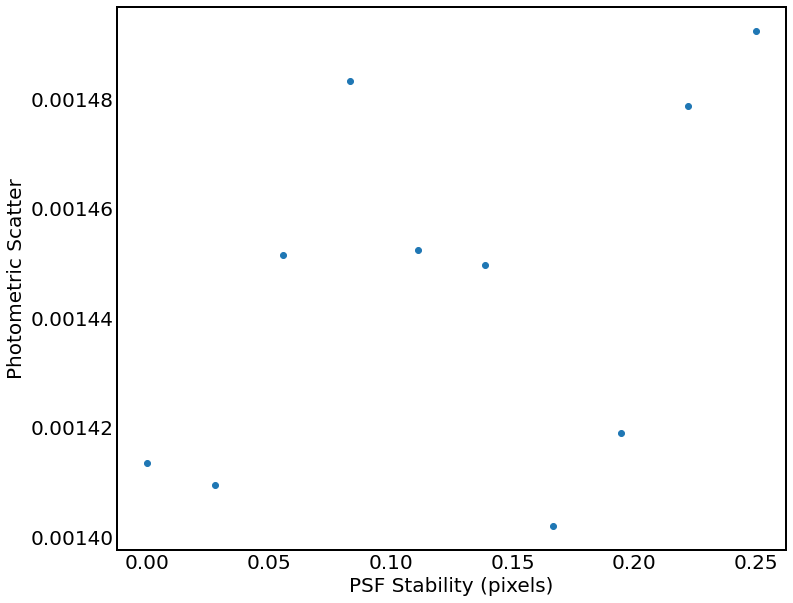

In [317]:
#dsig=np.array([0.0,0.1,0.2,0.15,0.18,0.2,0.25,0.22,0.23,0.24,0.21,0.23])
#pscat=np.array([0.00137,0.00128,0.00208,0.00136,0.00133,0.00167,0.01174,0.00208,0.0189,0.0111,0.002177,0.00293])


matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(12,10)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2,color='white')
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2,color='grey')
ax.scatter(dsig,pscat)

ax.set_xlabel('PSF Stability (pixels)')
ax.set_ylabel('Photometric Scatter')
fig.show()

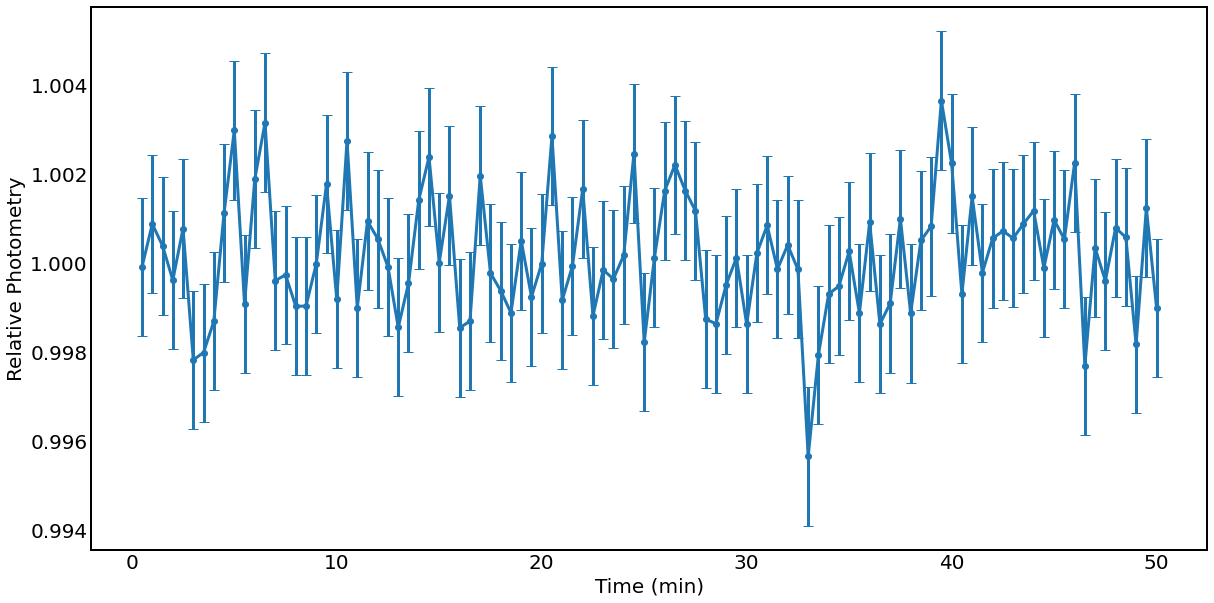

In [271]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(20,10)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2,color='white')
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2,color='grey')

medphot=np.median(phot_array)
ax.scatter(time/60,phot_array/medphot)
ax.errorbar(time/60,phot_array/medphot,phot_err_array/medphot,capsize=5.0,lw=3)
#ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
#ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))

ax.set_xlabel('Time (min)')
ax.set_ylabel('Relative Photometry')

fig.show()

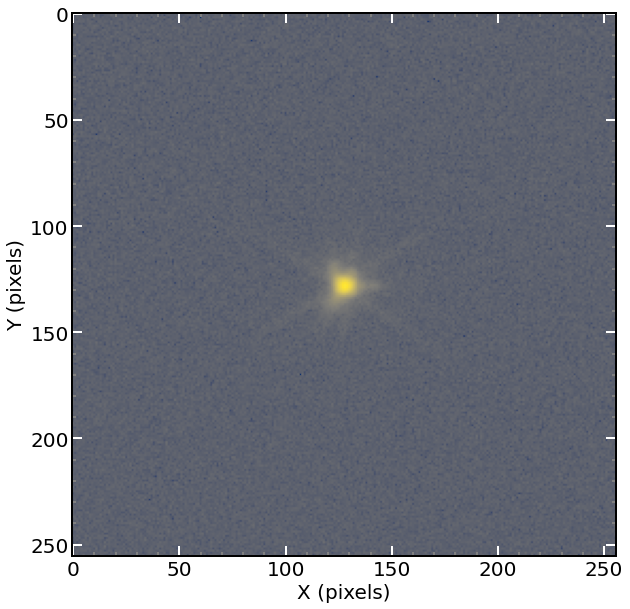

In [331]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(20,10)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2,color='white')
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2,color='grey')

cmap = plt.get_cmap('cividis')
ax.imshow(pixels_final-np.min(pixels_final)+1,interpolation=None,cmap=cmap,norm=LogNorm())

ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

fig.show()

128.22008844732537 128.04835658946035
